In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read in the file. Separate target from predictors in $y$ and $X$.

In [2]:
d = pd.read_hdf('../data/shower-shapes.h5')

In [3]:
y = d['shower_class'].values
del d['shower_class']

In [4]:
d.shape

(300000, 20)

In [5]:
X = d.values

Turn labels into classes, and select only photons and positrons for e-gamma classification.

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['eplus', 'gamma', 'piplus'], dtype=object)

0 = $e^+$

1 = $\gamma$

2 = $\pi^+$

In [9]:
# cut out gamma for now
X = X[y != 1]
y = y[y != 1]
y[y == 2] = 1

In [10]:
ix = range(len(y))

In [11]:
X_train, X_test, y_train, y_test, ix_train, ix_test = train_test_split(
    X, y, ix, train_size=0.65)

In [12]:
np.save('ix_train_epi.npy', ix_train)

Train a series of BDTs with cross validation for hyperparam search.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [17]:
base_clf = GradientBoostingClassifier(verbose=1)
parameters = {
    'n_estimators':[100, 200, 300, 400],
    'max_depth':[3, 5, 10]
}

In [18]:
clf = GridSearchCV(base_clf, parameters, n_jobs=4)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
      Iter       Train Loss   Remaining Time 
         1           1.2022            1.97m
         1           1.2023            1.98m
         1           1.2022            1.79m
         1           1.2023            3.92m
         2           1.0513            1.94m
         2           1.0513            1.96m
         2           1.0517            1.81m
         2           1.0513            3.73m
         3           0.9258            1.74m
         3           0.9257            1.92m
         3           0.9255            1.94m
         3           0.9257            3.79m
         4           0.8198            1.72m
         4           0.8191            1.85m
         4           0.8190            1.88m
         4           0.8191            3.73m
         5           0.7290            1.76m
         5           0.7278            1.88m
      

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [100, 200, 300, 400], 'max_depth': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [19]:
clf.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=400, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

Check classifier performance using different metrics:

In [20]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

In [21]:
y_hat = clf.predict(X_test)

In [22]:
y_hat_prob = clf.predict_proba(X_test)

In [23]:
print classification_report(y_test, y_hat)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     34957
          1       1.00      1.00      1.00     35043

avg / total       1.00      1.00      1.00     70000



In [24]:
accuracy_score(y_test, y_hat)

0.99815714285714285

In [25]:
roc_auc_score(y_test>0, y_hat_prob[:, 1])

0.9998671679627702

In [26]:
fpr, tpr, _ = roc_curve(y_test>0, y_hat_prob[:, 1])

Train a NN on this same problem

In [28]:
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model

x = Input(shape=(X_train.shape[-1], ))

h = Dense(256)(x)
h = Dropout(0.2)(LeakyReLU()(h))
h = BatchNormalization()(h)

h = Dense(256)(h)
h = Dropout(0.5)(LeakyReLU()(h))
h = BatchNormalization()(h)

h = Dense(256)(h)
h = Dropout(0.5)(LeakyReLU()(h))
h = BatchNormalization()(h)

h = Dense(32)(h)
h = Dropout(0.5)(LeakyReLU()(h))

h = Dense(1)(h)
y = Activation('sigmoid')(h)

net = Model(x, y)

In [29]:
net.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 20)            0                                            
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 256)           5376        input_2[0][0]                    
____________________________________________________________________________________________________
leakyrelu_5 (LeakyReLU)          (None, 256)           0           dense_6[0][0]                    
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 256)           0           leakyrelu_5[0][0]                
___________________________________________________________________________________________

In [30]:
net.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

Plot the scaled input variables just to make sure nothing went wrong

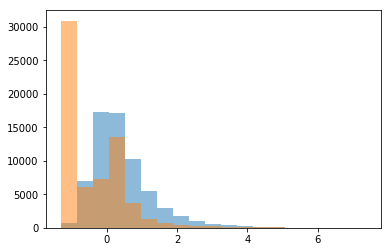

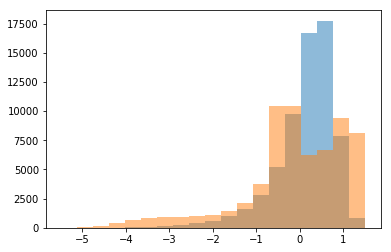

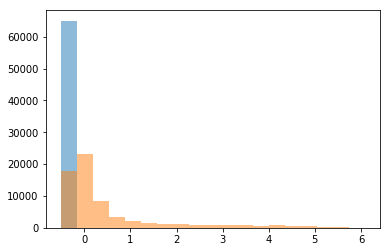

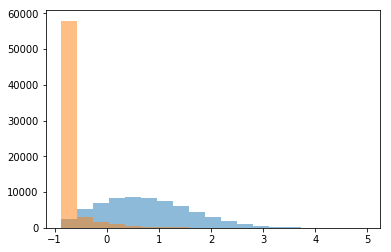

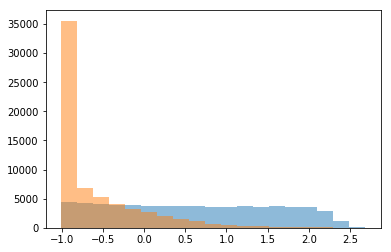

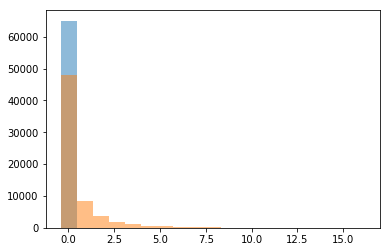

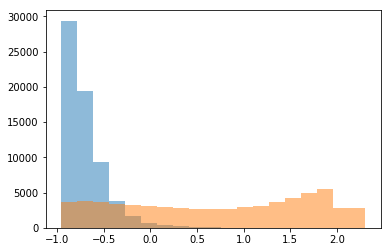

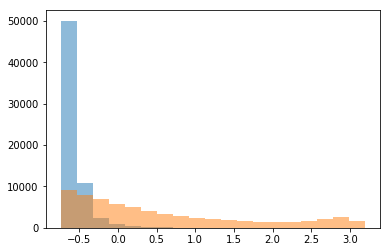

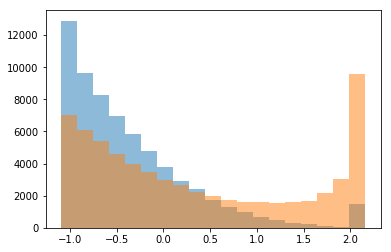

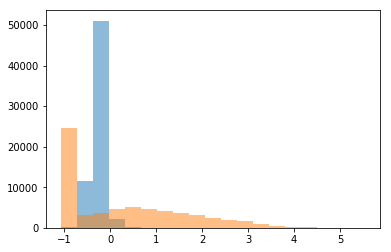

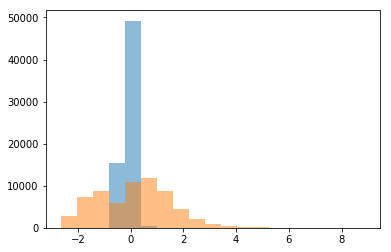

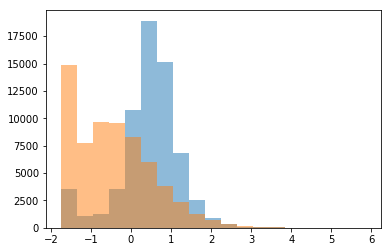

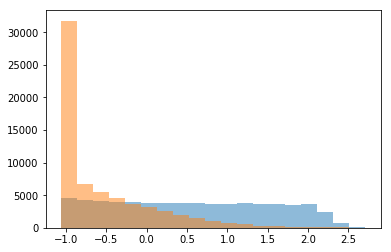

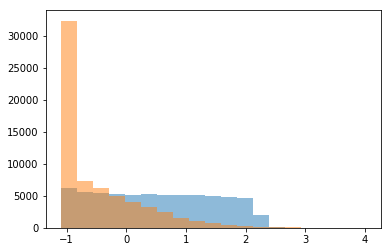

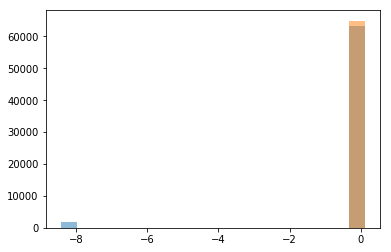

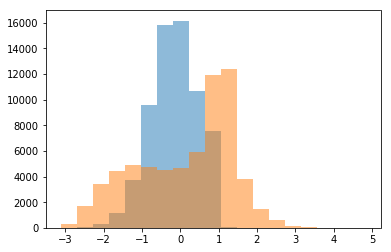

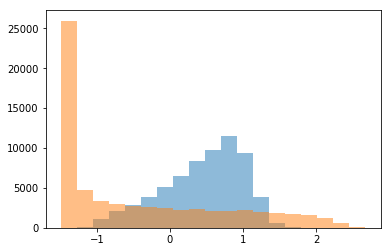

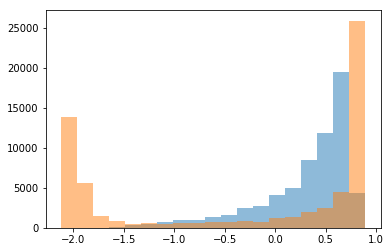

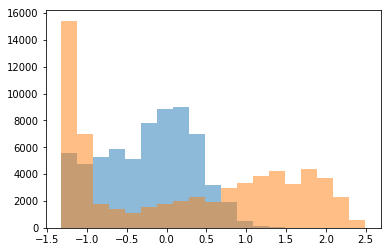

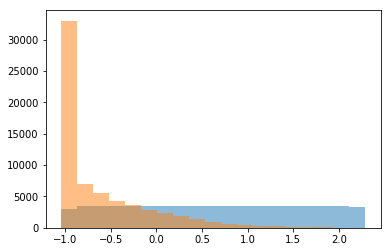

In [32]:
for i in range(X_train.shape[1]):
    bins = np.linspace(X_train_scaled[:, i].min(), X_train_scaled[:, i].max(), 20)
    _ = plt.hist(X_train_scaled[:, i][y_train == 0], alpha=0.5, bins=bins)
    _ = plt.hist(X_train_scaled[:, i][y_train == 1], alpha=0.5, bins=bins)
    plt.show()

In [35]:
weights_file = 'keras_model_shower_shapes_epi.h5'
from keras.callbacks import EarlyStopping, ModelCheckpoint
try:
    history = net.fit(
        X_train_scaled, y_train,
        batch_size=64, 
        callbacks = [
            EarlyStopping(verbose=True, patience=20, monitor='val_loss'),
            ModelCheckpoint(weights_file, monitor='val_loss', verbose=True, save_best_only=True)
        ],
    nb_epoch=100, 
    validation_split = 0.2,
    verbose=0) 

except KeyboardInterrupt:
    print 'Training ended early.'

print 'Loading weights of best model'
net.load_weights(weights_file)

Epoch 00000: val_loss improved from inf to 0.01078, saving model to keras_model_shower_shapes_epi.h5
Epoch 00001: val_loss improved from 0.01078 to 0.00776, saving model to keras_model_shower_shapes_epi.h5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss improved from 0.00776 to 0.00772, saving model to keras_model_shower_shapes_epi.h5
Epoch 00006: val_loss improved from 0.00772 to 0.00771, saving model to keras_model_shower_shapes_epi.h5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.00771 to 0.00722, saving model to keras_model_shower_shapes_epi.h5
Epoch 00009: val_loss improved from 0.00722 to 0.00690, saving model to keras_model_shower_shapes_epi.h5
Epoch 00010: val_loss did not improve
Epoch 00011: val_loss did not improve
Epoch 00012: val_loss did not improve
Epoch 00013: val_loss did not improve
Epoch 00014: val_loss improved from 0.00690 to 0.00675, saving model t

In [36]:
y_hat_proba_net = net.predict(X_test_scaled, verbose=1)

69984/70000 [============================>.] - ETA: 0s  

In [37]:
y_hat_net = (y_hat_proba_net > 0.5).astype(float)

In [38]:
print classification_report(y_test, y_hat_net)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     34957
          1       1.00      1.00      1.00     35043

avg / total       1.00      1.00      1.00     70000



In [39]:
accuracy_score(y_test, y_hat_net)

0.99819999999999998

In [45]:
roc_auc_score(y_test>0, y_hat_proba_net)

0.99989189126539346

In [40]:
fpr_net, tpr_net, _ = roc_curve(y_test>0, y_hat_proba_net)

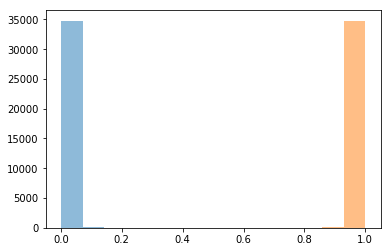

In [41]:
# Net output
bins = np.linspace(0, 1, 15)
_ = plt.hist(y_hat_proba_net[y_test == 0], alpha=0.5, bins=bins)
_ = plt.hist(y_hat_proba_net[y_test == 1], alpha=0.5, bins=bins)

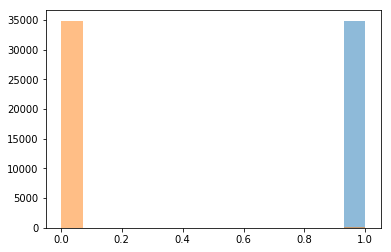

In [42]:
# BDT output
bins = np.linspace(0, 1, 15)
_ = plt.hist(y_hat_prob[:, 0][y_test == 0], alpha=0.5, bins=bins)
_ = plt.hist(y_hat_prob[:, 0][y_test == 1], alpha=0.5, bins=bins)

(0.9, 1.01)

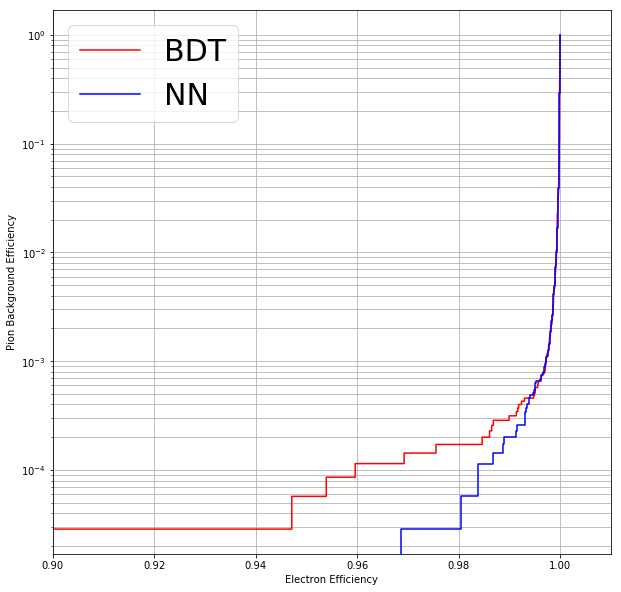

In [61]:
plt.figure(figsize=(10,10))
plt.plot(tpr, fpr, color='red', label='BDT')
plt.plot(tpr_net, fpr_net, color='blue', label='NN')
plt.yscale('log')
plt.grid('on', 'both')
plt.xlabel('Electron Efficiency')
plt.ylabel('Pion Background Efficiency')
plt.legend(fontsize=30, loc='upper left')
plt.xlim(0.9, 1.01)
# lower = better !!

### Pion Acceptance at 99% Electron Efficiency

In [77]:
print 'At 99% electron efficiency, the NN accepts {:0.3f}% of pions.'.format(
    100 * fpr_net[np.argmin(abs(tpr_net - 0.99))]
)

At 99% electron efficiency, the NN accepts 0.017% of pions.


In [78]:
print 'At 99% electron efficiency, the BDT accepts {:0.3f}% of pions.'.format(
    100 * fpr[np.argmin(abs(tpr - 0.99))]
)

At 99% electron efficiency, the BDT accepts 0.029% of pions.
